In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_log_error, mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
pd.options.mode.chained_assignment = None

In [43]:
#load the train and validation dataset
df = pd.read_csv('TrainAndValid.csv',parse_dates=["saledate"], low_memory = False)

In [44]:
df.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000.0,999089,3157,121,3.0,2004,68.0,Low,2006-11-16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000.0,117657,77,121,3.0,1996,4640.0,Low,2004-03-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000.0,434808,7009,121,3.0,2001,2838.0,High,2004-02-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500.0,1026470,332,121,3.0,2001,3486.0,High,2011-05-19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000.0,1057373,17311,121,3.0,2007,722.0,Medium,2009-07-23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [45]:
df.info()
# NB! a lot of null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   SalesID                   412698 non-null  int64         
 1   SalePrice                 412698 non-null  float64       
 2   MachineID                 412698 non-null  int64         
 3   ModelID                   412698 non-null  int64         
 4   datasource                412698 non-null  int64         
 5   auctioneerID              392562 non-null  float64       
 6   YearMade                  412698 non-null  int64         
 7   MachineHoursCurrentMeter  147504 non-null  float64       
 8   UsageBand                 73670 non-null   object        
 9   saledate                  412698 non-null  datetime64[ns]
 10  fiModelDesc               412698 non-null  object        
 11  fiBaseModel               412698 non-null  object        
 12  fi

In [46]:
# NAke some extra columns to plot stats
df["SaleYear"] = df.saledate.dt.year
df["SaleMonth"] = df.saledate.dt.month
df["SaleDay"] = df.saledate.dt.day
df["SaleDayOfWeek"] = df.saledate.dt.dayofweek
df["SaleDayOfYear"] = df.saledate.dt.dayofyear

### 1. Lag en enkel statistikk for noen utvalgte variabler, både visuelt og numerisk. (Snitt, Max, Min)

In [47]:
stat_cols = ['SalePrice', 'YearMade', 'SaleYear']
df[stat_cols].describe()

,SalePrice,YearMade,SaleYear
count,412698.000000,412698.000000,412698.000000
mean,31215.181414,1899.049637,2004.317382
std,23141.743695,292.190243,5.821090
min,4750.000000,1000.000000,1989.000000
25%,14500.000000,1985.000000,2000.000000
50%,24000.000000,1995.000000,2006.000000
75%,40000.000000,2001.000000,2009.000000
max,142000.000000,2014.000000,2012.000000


In [48]:
# Replace unrealistic YearMade by Nans
df['YearMade'][(df['YearMade'] < 1900)] = np.nan

In [49]:
df[stat_cols].describe()

,SalePrice,YearMade,SaleYear
count,412698.000000,373307.000000,412698.000000
mean,31215.181414,1993.916500,2004.317382
std,23141.743695,9.688749,5.821090
min,4750.000000,1919.000000,1989.000000
25%,14500.000000,1988.000000,2000.000000
50%,24000.000000,1996.000000,2006.000000
75%,40000.000000,2001.000000,2009.000000
max,142000.000000,2014.000000,2012.000000


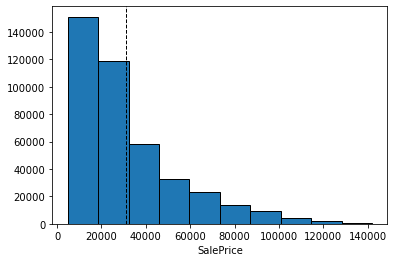

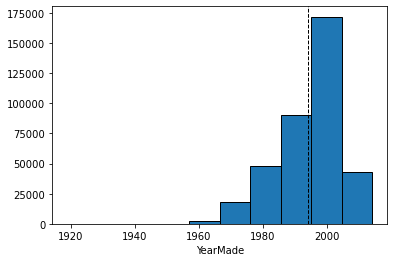

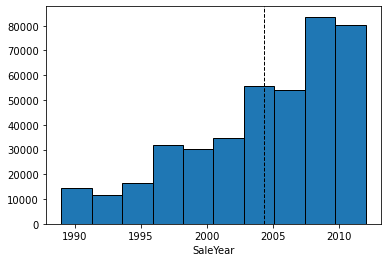

In [50]:
for i in stat_cols:
    x = df[i]
    plt.hist(x, edgecolor='k')
    plt.xlabel(str(i))
    plt.axvline(x.mean(), color='k', linestyle='dashed', linewidth=1)
    plt.show()

### 2. Gjør en vurdering av mengden manglende verdier, konsekvens av dette, og nevn noen metoder for å håndtere det

In [51]:
# Percent missing data
missing_perc = df.isnull().sum()/len(df)
missing_perc

SalesID                     0.000000
SalePrice                   0.000000
MachineID                   0.000000
ModelID                     0.000000
datasource                  0.000000
auctioneerID                0.048791
YearMade                    0.095448
MachineHoursCurrentMeter    0.642586
UsageBand                   0.821492
saledate                    0.000000
fiModelDesc                 0.000000
fiBaseModel                 0.000000
fiSecondaryDesc             0.340993
fiModelSeries               0.857845
fiModelDescriptor           0.818715
ProductSize                 0.524851
fiProductClassDesc          0.000000
state                       0.000000
ProductGroup                0.000000
ProductGroupDesc            0.000000
Drive_System                0.740520
Enclosure                   0.000809
Forks                       0.520921
Pad_Type                    0.803498
Ride_Control                0.629928
Stick                       0.803498
Transmission                0.544444
T

In [52]:
# Let's drop these columns that have more nans than a threshold value
drop_thr = 0.7
cols_to_be_dropped = missing_perc.index[missing_perc.values > drop_thr]
print(cols_to_be_dropped)
df = df.drop(cols_to_be_dropped, axis=1)

Index(['UsageBand', 'fiModelSeries', 'fiModelDescriptor', 'Drive_System',
       'Pad_Type', 'Stick', 'Turbocharged', 'Blade_Extension', 'Blade_Width',
       'Enclosure_Type', 'Engine_Horsepower', 'Pushblock', 'Ripper',
       'Scarifier', 'Tip_Control', 'Tire_Size', 'Coupler_System',
       'Grouser_Tracks', 'Hydraulics_Flow', 'Track_Type',
       'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb', 'Pattern_Changer',
       'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type', 'Travel_Controls',
       'Differential_Type', 'Steering_Controls'],
      dtype='object')


In [53]:
# After dropping:
df.isnull().sum()/len(df)

SalesID                     0.000000
SalePrice                   0.000000
MachineID                   0.000000
ModelID                     0.000000
datasource                  0.000000
auctioneerID                0.048791
YearMade                    0.095448
MachineHoursCurrentMeter    0.642586
saledate                    0.000000
fiModelDesc                 0.000000
fiBaseModel                 0.000000
fiSecondaryDesc             0.340993
ProductSize                 0.524851
fiProductClassDesc          0.000000
state                       0.000000
ProductGroup                0.000000
ProductGroupDesc            0.000000
Enclosure                   0.000809
Forks                       0.520921
Ride_Control                0.629928
Transmission                0.544444
Hydraulics                  0.200062
Coupler                     0.465277
SaleYear                    0.000000
SaleMonth                   0.000000
SaleDay                     0.000000
SaleDayOfWeek               0.000000
S

In [54]:
# Now we get easier to comprehend df
df.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,saledate,fiModelDesc,...,Forks,Ride_Control,Transmission,Hydraulics,Coupler,SaleYear,SaleMonth,SaleDay,SaleDayOfWeek,SaleDayOfYear
0,1139246,66000.0,999089,3157,121,3.0,2004.0,68.0,2006-11-16,521D,...,None or Unspecified,None or Unspecified,NaN,2 Valve,None or Unspecified,2006,11,16,3,320
1,1139248,57000.0,117657,77,121,3.0,1996.0,4640.0,2004-03-26,950FII,...,None or Unspecified,None or Unspecified,NaN,2 Valve,None or Unspecified,2004,3,26,4,86
2,1139249,10000.0,434808,7009,121,3.0,2001.0,2838.0,2004-02-26,226,...,None or Unspecified,NaN,NaN,Auxiliary,None or Unspecified,2004,2,26,3,57
3,1139251,38500.0,1026470,332,121,3.0,2001.0,3486.0,2011-05-19,PC120-6E,...,NaN,NaN,NaN,2 Valve,None or Unspecified,2011,5,19,3,139
4,1139253,11000.0,1057373,17311,121,3.0,2007.0,722.0,2009-07-23,S175,...,None or Unspecified,NaN,NaN,Auxiliary,None or Unspecified,2009,7,23,3,204


For more handlig of uncomplete rows see part 3 

### 3. Gjør en vurdering om datatyper, kontinuerlige/kategoriske variable, og hvordan dette håndteres.

In [55]:
# Still they are some columns that lack data
df.isnull().sum()/len(df) # Lacking in percent

SalesID                     0.000000
SalePrice                   0.000000
MachineID                   0.000000
ModelID                     0.000000
datasource                  0.000000
auctioneerID                0.048791
YearMade                    0.095448
MachineHoursCurrentMeter    0.642586
saledate                    0.000000
fiModelDesc                 0.000000
fiBaseModel                 0.000000
fiSecondaryDesc             0.340993
ProductSize                 0.524851
fiProductClassDesc          0.000000
state                       0.000000
ProductGroup                0.000000
ProductGroupDesc            0.000000
Enclosure                   0.000809
Forks                       0.520921
Ride_Control                0.629928
Transmission                0.544444
Hydraulics                  0.200062
Coupler                     0.465277
SaleYear                    0.000000
SaleMonth                   0.000000
SaleDay                     0.000000
SaleDayOfWeek               0.000000
S

One of the standard methods is to fill these empty fields with median values.
But to do so we need to convert categorical data to numerical

In [56]:
# Following columns aren't numeric:
for label, content in df.items():
    #if not pd.api.types.is_numeric_dtype(content):
    if pd.api.types.is_string_dtype(content):
        print(label)

fiModelDesc
fiBaseModel
fiSecondaryDesc
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Enclosure
Forks
Ride_Control
Transmission
Hydraulics
Coupler


In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 28 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   SalesID                   412698 non-null  int64         
 1   SalePrice                 412698 non-null  float64       
 2   MachineID                 412698 non-null  int64         
 3   ModelID                   412698 non-null  int64         
 4   datasource                412698 non-null  int64         
 5   auctioneerID              392562 non-null  float64       
 6   YearMade                  373307 non-null  float64       
 7   MachineHoursCurrentMeter  147504 non-null  float64       
 8   saledate                  412698 non-null  datetime64[ns]
 9   fiModelDesc               412698 non-null  object        
 10  fiBaseModel               412698 non-null  object        
 11  fiSecondaryDesc           271971 non-null  object        
 12  Pr

In [70]:
# Now we convert
for label, content in df.items():
    if pd.api.types.is_string_dtype(content):
        # Get understanding which categories will be changed
        print(label, df[label].astype('category').cat.categories)
        df[label] = content.astype('category').cat.as_ordered()
        df[label] = pd.Categorical(content).codes+1 # +1 because we want to avoid -1 category

fiModelDesc Index(['100C', '104', '1066', '1066E', '1080', '1080B', '1088', '1088CK',
       '1088LT', '1088TTL',
       ...
       'ZX600LC', 'ZX70', 'ZX75', 'ZX75US', 'ZX75USA', 'ZX80', 'ZX800',
       'ZX800LC', 'ZX80LCK', 'ZX850H'],
      dtype='object', length=5059)
fiBaseModel Index(['10', '100', '104', '1066', '1080', '1088', '10DG', '11', '110', '1105',
       ...
       'ZX370', 'ZX450', 'ZX460', 'ZX50', 'ZX600', 'ZX70', 'ZX75', 'ZX80',
       'ZX800', 'ZX850'],
      dtype='object', length=1961)
fiSecondaryDesc Index([' MSR SPIN ACE', '#NAME?', '-2', '-3', '-5', '-5L', '-6', '-7', '0.7',
       '1',
       ...
       'XP', 'XT', 'Z', 'ZF', 'ZHS', 'ZHS G', 'ZT', 'ZTM', 'ZTS', 'ZX'],
      dtype='object', length=177)
ProductSize Index(['Compact', 'Large', 'Large / Medium', 'Medium', 'Mini', 'Small'], dtype='object')
fiProductClassDesc Index(['Backhoe Loader - 0.0 to 14.0 Ft Standard Digging Depth',
       'Backhoe Loader - 14.0 to 15.0 Ft Standard Digging Depth',
       'Backho

In [72]:
# So now all categories are numerical
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 28 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   SalesID                   412698 non-null  int64         
 1   SalePrice                 412698 non-null  float64       
 2   MachineID                 412698 non-null  int64         
 3   ModelID                   412698 non-null  int64         
 4   datasource                412698 non-null  int64         
 5   auctioneerID              392562 non-null  float64       
 6   YearMade                  373307 non-null  float64       
 7   MachineHoursCurrentMeter  147504 non-null  float64       
 8   saledate                  412698 non-null  datetime64[ns]
 9   fiModelDesc               412698 non-null  int16         
 10  fiBaseModel               412698 non-null  int16         
 11  fiSecondaryDesc           412698 non-null  int16         
 12  Pr

In [74]:
# Still we have problem that some categories have nans. Again how much of them do we have?
df.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                     39391
MachineHoursCurrentMeter    265194
saledate                         0
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc                  0
ProductSize                      0
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Enclosure                        0
Forks                            0
Ride_Control                     0
Transmission                     0
Hydraulics                       0
Coupler                          0
SaleYear                         0
SaleMonth                        0
SaleDay                          0
SaleDayOfWeek                    0
SaleDayOfYear                    0
dtype: int64

In [75]:
# Let's fill them with median values
for label, content in df.items():
    if pd.isnull(content).sum():
        # Add a binary column which tells if the data was missing our not
        df[label+"_is_missing"] = pd.isnull(content)
        # Fill missing numeric values with median since it's more robust than the mean
        df[label] = content.fillna(content.median())

In [81]:
# Now we shouln't have any missing values 
df.isna().sum()

SalesID                                0
SalePrice                              0
MachineID                              0
ModelID                                0
datasource                             0
auctioneerID                           0
YearMade                               0
MachineHoursCurrentMeter               0
saledate                               0
fiModelDesc                            0
fiBaseModel                            0
fiSecondaryDesc                        0
ProductSize                            0
fiProductClassDesc                     0
state                                  0
ProductGroup                           0
ProductGroupDesc                       0
Enclosure                              0
Forks                                  0
Ride_Control                           0
Transmission                           0
Hydraulics                             0
Coupler                                0
SaleYear                               0
SaleMonth       

In [78]:
# As a last thing let's sort the table by sale year ???

In [80]:
# Let's save cleaned df
df.to_csv('TrainAndValidCleaned.csv', index=False)